<a href="https://colab.research.google.com/github/georgealappat-collab/IDC409-GRP32/blob/main/Leaf_Classification(XG_boost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
dataset_path = r"/content/drive/MyDrive/Leaf Classification"


In [5]:
!pip install xgboost seaborn tabulate


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    cohen_kappa_score, matthews_corrcoef
)
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")


In [7]:
# 👇 Update this path if needed
dataset_path = "/content/drive/MyDrive/Leaf Classification"

species_mapping = {
    "leaf1": "Acer",
    "leaf2": "Quercus",
    "leaf3": "Salix alba",
    "leaf4": "Ulmus carpinifolia",
    "leaf5": "Ulmus glabra"
}

os.makedirs("results", exist_ok=True)


In [8]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return np.zeros((512,))
    image = cv2.resize(image, (128, 128))
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist


In [9]:
data, labels = [], []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            data.append(extract_features(img_path))
            labels.append(species_mapping.get(folder, folder))

data, labels = np.array(data), np.array(labels)
print(f"✅ Loaded {len(data)} images across {len(np.unique(labels))} species.")


✅ Loaded 375 images across 5 species.


In [10]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
display_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(
    data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)
print("✅ Data encoded and split successfully!")


✅ Data encoded and split successfully!


In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

print("🔍 Running randomized hyperparameter tuning...")

param_dist = {
    'n_estimators': randint(80, 200),
    'learning_rate': uniform(0.03, 0.07),
    'max_depth': randint(3, 7),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.8, 0.2),
    'gamma': uniform(0, 0.3)
}

random_search = RandomizedSearchCV(
    estimator=XGBClassifier(objective='multi:softprob', eval_metric='mlogloss'),
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\n✅ Best Hyperparameters Found:")
print(random_search.best_params_)
best_model = random_search.best_estimator_


🔍 Running randomized hyperparameter tuning...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

✅ Best Hyperparameters Found:
{'colsample_bytree': np.float64(0.9510722820635306), 'gamma': np.float64(0.12754676234737342), 'learning_rate': np.float64(0.04455591640077322), 'max_depth': 6, 'n_estimators': 133, 'subsample': np.float64(0.7093939877366675)}


In [12]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=display_names)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc*100:.2f}%")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Corrcoef: {mcc:.4f}")

print("\n=== Classification Report ===\n")
print(report)

Accuracy: 93.33%
Weighted F1 Score: 0.9334
Cohen's Kappa: 0.9167
Matthews Corrcoef: 0.9185

=== Classification Report ===

                      precision    recall  f1-score   support

                Acer       1.00      0.93      0.97        15
             Quercus       0.88      1.00      0.94        15
Salix alba 'Sericea'       1.00      1.00      1.00        15
  Ulmus carpinifolia       1.00      0.80      0.89        15
        Ulmus glabra       0.82      0.93      0.88        15

            accuracy                           0.93        75
           macro avg       0.94      0.93      0.93        75
        weighted avg       0.94      0.93      0.93        75



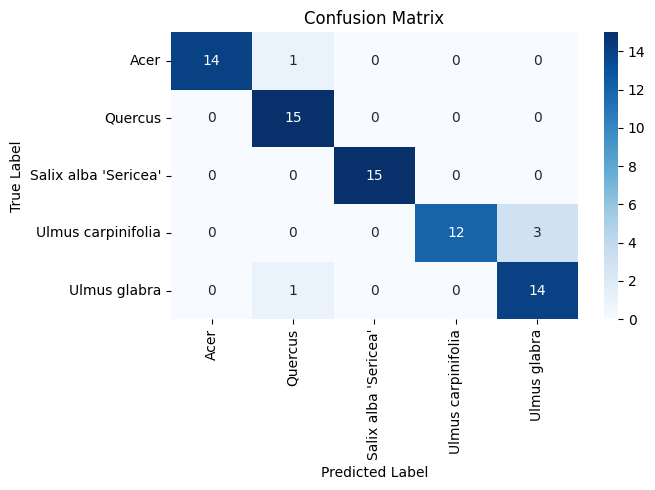

In [13]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=display_names, yticklabels=display_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

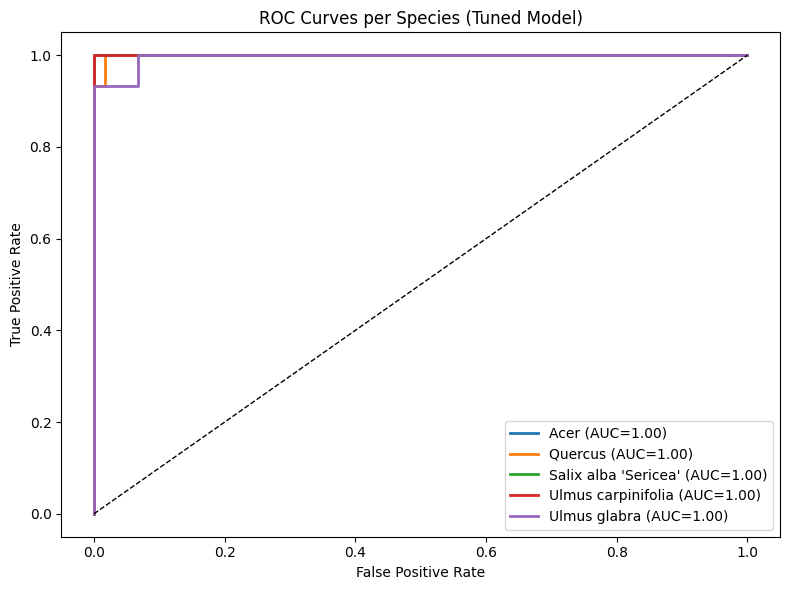

In [14]:
y_test_bin = label_binarize(y_test, classes=range(len(display_names)))

plt.figure(figsize=(8, 6))
for i, species in enumerate(display_names):
    if np.sum(y_test_bin[:, i]) == 0:
        continue
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{species} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curves per Species (Tuned Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


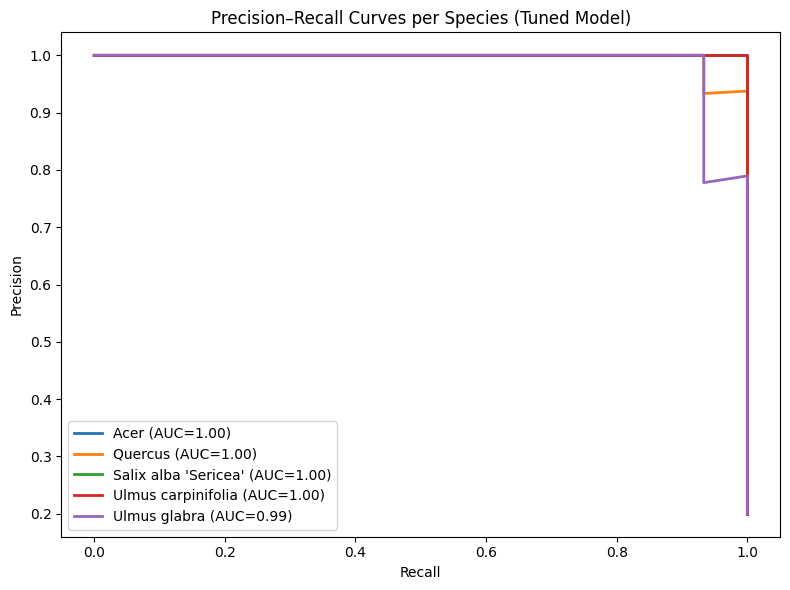

In [15]:
plt.figure(figsize=(8, 6))
for i, species in enumerate(display_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f"{species} (AUC={average_precision_score(y_test_bin[:, i], y_prob[:, i]):.2f})")

plt.title("Precision–Recall Curves per Species (Tuned Model)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
